In [1]:
def euler_sim(M, x0 ,dt, T, Perturbation=None):
    x = x0
    X = []
    for t in np.linspace(0, T, int(T/dt)):
        if Perturbation is not None:
            x = x + 1j * (M+Perturbation(t)) @ x *dt
        else:
            x = x + 1j*dt*M @ x
        X.append(x)

    return np.array(X, dtype=np.complex128)
def rk4_sim(M, x0, dt, T, Perturbation=None):

    x = x0
    X = []
    for t in np.linspace(0, T, int(T/dt)):
        if Perturbation is not None:
            k1 = 1j * (M+Perturbation(t)) @ x
            k2 = 1j * (M+Perturbation(t+dt/2)) @ (x + k1*dt/2)
            k3 = 1j * (M+Perturbation(t+dt/2)) @ (x + k2*dt/2)
            k4 = 1j * (M+Perturbation(t+dt)) @ (x + k3*dt)
        else:
            k1 = 1j * M @ x
            k2 = 1j * M @ (x + k1*dt/2)
            k3 = 1j * M @ (x + k2*dt/2)
            k4 = 1j * M @ (x + k3*dt)
        x = x + (k1 + 2*k2 + 2*k3 + k4)*dt/6
        X.append(x)

    return np.array(X, dtype=np.complex128)

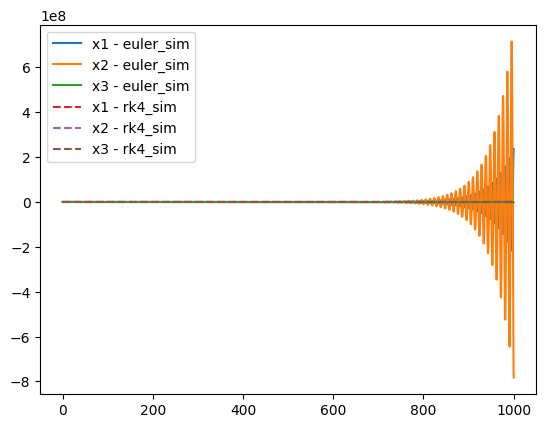

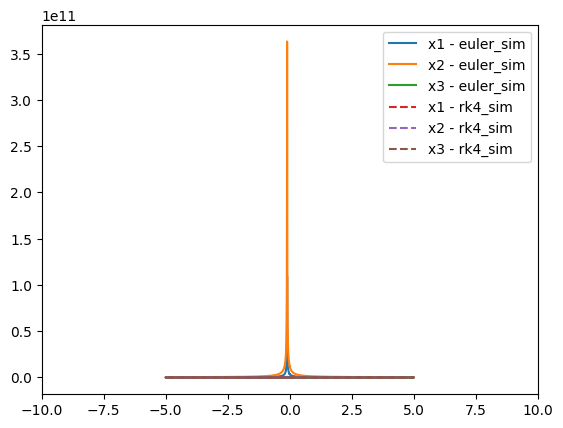

In [6]:
import numpy as np
import matplotlib.pyplot as plt

#plot interactivley



def plot_sim(M, x0, dt, T, algo = euler_sim,  Perturbation=None, plots=None, linestyle='-'):
    if plots is None:
        fig, ax = plt.subplots()
        fig_fft, ax_fft = plt.subplots()
    else:
        fig, ax, fig_fft, ax_fft = plots

    #X = euler_sim(M, x0, dt, T, Perturbation)
    X = algo(M, x0, dt, T, Perturbation)
    t = np.linspace(0, T, int(T/dt))
    # plot all the states
    for i in range(X.shape[1]):
        ax.plot(t,np.real(X[:,i]), label=f"x{i+1} - {algo.__name__}", linestyle=linestyle)
    ax.legend()

    # plot the fourier transform

    W = np.fft.fft(X, axis=0)
    # move fft
    #W = np.fft.fftshift(W, axes=0)
    # get axis scaling
    freq = np.fft.fftfreq(W.shape[0], d=dt)
    # plot
    for i in range(W.shape[1]):
        ax_fft.plot(freq, np.abs(W[:,i]), label=f"x{i+1} - {algo.__name__}", linestyle=linestyle)
    ax_fft.set_xlim(-10, 10)
    ax_fft.legend()

    return fig, ax, fig_fft, ax_fft

OMS = 2 #Order of magnitude scaling

E_i = 0
E_phi = -0.3
E_psi = -0.2
Omega_iphi = 0.1
Omega_ipsi = 0.001
g_phipsi = 0

#laser
laser = lambda t: np.array(
    [
        [np.sin(t), 0, 0],
        [0, 0, 0],
        [0, 0, 0],
    ]
    )
laser = None

M = np.array(
    [
    [E_i, np.conjugate(Omega_iphi), np.conjugate(Omega_ipsi)], 
    [Omega_iphi, E_phi, np.conjugate(g_phipsi)],
    [Omega_ipsi, g_phipsi, E_psi],
    ]
)
M = M*OMS

def compare_algos(M, x0, dt, T, Perturbation=None):
    plots = plot_sim(M, x0, dt, T, euler_sim, Perturbation)

    plot_sim(M, x0, dt, T, rk4_sim, Perturbation, plots=plots, linestyle='--')
    plt.show()    

    plots = plot_sim(M, x0, dt, T, rk4_sim, Perturbation, plots=plots, linestyle='-.')
    plots[0].show()
    plots[2].show()
compare_algos(M, np.array([1, 0, 0]), 0.1, 1000, laser)


In [3]:
# RK4 simulation
